In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 3*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = 4*torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 3*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = 4*torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 3*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 4, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)


# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


In [5]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [6]:
start_time = time.time()
n_epochs = 3000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p10_3k.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p10_3k.pth')


################################  0  ################################
Loss:  53.148929595947266
################################  1  ################################
Loss:  52.95332336425781
################################  2  ################################
Loss:  47.446468353271484
################################  3  ################################
Loss:  40.46723556518555
################################  4  ################################
Loss:  34.17806625366211
################################  5  ################################
Loss:  29.522811889648438
################################  6  ################################
Loss:  25.900938034057617
################################  7  ################################
Loss:  22.84705352783203
################################  8  ################################
Loss:  20.026653289794922
################################  9  ################################
Loss:  17.21038818359375
################################  10  #######

Loss:  0.017682507634162903
################################  85  ################################
Loss:  0.017209509387612343
################################  86  ################################
Loss:  0.016765141859650612
################################  87  ################################
Loss:  0.016351960599422455
################################  88  ################################
Loss:  0.01596248894929886
################################  89  ################################
Loss:  0.015602094121277332
################################  90  ################################
Loss:  0.015269435942173004
################################  91  ################################
Loss:  0.014985596761107445
################################  92  ################################
Loss:  0.014701800420880318
################################  93  ################################
Loss:  0.014468422159552574
################################  94  ################################
Loss:  0.01

Loss:  0.006170979700982571
################################  168  ################################
Loss:  0.006147697567939758
################################  169  ################################
Loss:  0.006121940910816193
################################  170  ################################
Loss:  0.006094350945204496
################################  171  ################################
Loss:  0.006063183303922415
################################  172  ################################
Loss:  0.006039939355105162
################################  173  ################################
Loss:  0.00601621251553297
################################  174  ################################
Loss:  0.005997668020427227
################################  175  ################################
Loss:  0.0059759123250842094
################################  176  ################################
Loss:  0.005965790711343288
################################  177  ################################


Loss:  0.005653555504977703
################################  251  ################################
Loss:  0.005646128207445145
################################  252  ################################
Loss:  0.005637929309159517
################################  253  ################################
Loss:  0.005628318525850773
################################  254  ################################
Loss:  0.005618956405669451
################################  255  ################################
Loss:  0.005608211271464825
################################  256  ################################
Loss:  0.005598066374659538
################################  257  ################################
Loss:  0.005587303079664707
################################  258  ################################
Loss:  0.005575329530984163
################################  259  ################################
Loss:  0.005563221871852875
################################  260  ################################


Loss:  0.005951736122369766
################################  333  ################################
Loss:  0.005951662082225084
################################  334  ################################
Loss:  0.005946997553110123
################################  335  ################################
Loss:  0.005948430392891169
################################  336  ################################
Loss:  0.005944058299064636
################################  337  ################################
Loss:  0.00594452815130353
################################  338  ################################
Loss:  0.0059395283460617065
################################  339  ################################
Loss:  0.005937569309026003
################################  340  ################################
Loss:  0.005934504792094231
################################  341  ################################
Loss:  0.005928227677941322
################################  342  ################################


Loss:  0.0058404430747032166
################################  415  ################################
Loss:  0.005824998952448368
################################  416  ################################
Loss:  0.005808848887681961
################################  417  ################################
Loss:  0.005790688097476959
################################  418  ################################
Loss:  0.005771367810666561
################################  419  ################################
Loss:  0.005751757882535458
################################  420  ################################
Loss:  0.00573322270065546
################################  421  ################################
Loss:  0.0057152207009494305
################################  422  ################################
Loss:  0.0056980932131409645
################################  423  ################################
Loss:  0.00568437622860074
################################  424  ################################

Loss:  0.005592993460595608
################################  497  ################################
Loss:  0.005614398047327995
################################  498  ################################
Loss:  0.005638706963509321
################################  499  ################################
Loss:  0.00566220935434103
################################  500  ################################
Loss:  0.0056900400668382645
################################  501  ################################
Loss:  0.005712591111660004
################################  502  ################################
Loss:  0.005738717503845692
################################  503  ################################
Loss:  0.005771672818809748
################################  504  ################################
Loss:  0.00580238364636898
################################  505  ################################
Loss:  0.00582851842045784
################################  506  ################################
Lo

Loss:  0.005718649365007877
################################  579  ################################
Loss:  0.005723823327571154
################################  580  ################################
Loss:  0.00573013536632061
################################  581  ################################
Loss:  0.005735686048865318
################################  582  ################################
Loss:  0.005747801624238491
################################  583  ################################
Loss:  0.005753147415816784
################################  584  ################################
Loss:  0.005768431816250086
################################  585  ################################
Loss:  0.005776085890829563
################################  586  ################################
Loss:  0.00578936655074358
################################  587  ################################
Loss:  0.0058031026273965836
################################  588  ################################
L

Loss:  0.005516133736819029
################################  661  ################################
Loss:  0.005510981660336256
################################  662  ################################
Loss:  0.005503947380930185
################################  663  ################################
Loss:  0.005504201631993055
################################  664  ################################
Loss:  0.005500452127307653
################################  665  ################################
Loss:  0.005499002989381552
################################  666  ################################
Loss:  0.005498167127370834
################################  667  ################################
Loss:  0.0054979342967271805
################################  668  ################################
Loss:  0.0055114105343818665
################################  669  ################################
Loss:  0.005511559545993805
################################  670  ###############################

Loss:  0.005811408162117004
################################  743  ################################
Loss:  0.005808738060295582
################################  744  ################################
Loss:  0.005806492641568184
################################  745  ################################
Loss:  0.00579781224951148
################################  746  ################################
Loss:  0.005798690486699343
################################  747  ################################
Loss:  0.005790699273347855
################################  748  ################################
Loss:  0.005780482664704323
################################  749  ################################
Loss:  0.005771340802311897
################################  750  ################################
Loss:  0.005759217776358128
################################  751  ################################
Loss:  0.005748702213168144
################################  752  ################################
L

Loss:  0.005689343437552452
################################  825  ################################
Loss:  0.005676992237567902
################################  826  ################################
Loss:  0.0056653982028365135
################################  827  ################################
Loss:  0.005651297979056835
################################  828  ################################
Loss:  0.005640031769871712
################################  829  ################################
Loss:  0.005625670775771141
################################  830  ################################
Loss:  0.005617495160549879
################################  831  ################################
Loss:  0.005606519058346748
################################  832  ################################
Loss:  0.005597865208983421
################################  833  ################################
Loss:  0.0055840034037828445
################################  834  ###############################

Loss:  0.005561936646699905
################################  907  ################################
Loss:  0.0055559659376740456
################################  908  ################################
Loss:  0.005551519338041544
################################  909  ################################
Loss:  0.005543643608689308
################################  910  ################################
Loss:  0.005541400983929634
################################  911  ################################
Loss:  0.005533263087272644
################################  912  ################################
Loss:  0.005528317764401436
################################  913  ################################
Loss:  0.005525545217096806
################################  914  ################################
Loss:  0.00551858264952898
################################  915  ################################
Loss:  0.005515877157449722
################################  916  ################################


Loss:  0.005624608136713505
################################  989  ################################
Loss:  0.0056210728362202644
################################  990  ################################
Loss:  0.005618310067802668
################################  991  ################################
Loss:  0.005610713269561529
################################  992  ################################
Loss:  0.005605793092399836
################################  993  ################################
Loss:  0.00559960026293993
################################  994  ################################
Loss:  0.005591536872088909
################################  995  ################################
Loss:  0.005583574995398521
################################  996  ################################
Loss:  0.005576035939157009
################################  997  ################################
Loss:  0.00556504400447011
################################  998  ################################
L

Loss:  0.005296539049595594
################################  1071  ################################
Loss:  0.005294875241816044
################################  1072  ################################
Loss:  0.005292267072945833
################################  1073  ################################
Loss:  0.005287340842187405
################################  1074  ################################
Loss:  0.005286580882966518
################################  1075  ################################
Loss:  0.005280189216136932
################################  1076  ################################
Loss:  0.005276903510093689
################################  1077  ################################
Loss:  0.005276590585708618
################################  1078  ################################
Loss:  0.005269649438560009
################################  1079  ################################
Loss:  0.005267079453915358
################################  1080  #######################

Loss:  0.005107471719384193
################################  1153  ################################
Loss:  0.005108959041535854
################################  1154  ################################
Loss:  0.005112908314913511
################################  1155  ################################
Loss:  0.005117499269545078
################################  1156  ################################
Loss:  0.005121137015521526
################################  1157  ################################
Loss:  0.00512643251568079
################################  1158  ################################
Loss:  0.005131478421390057
################################  1159  ################################
Loss:  0.005136569961905479
################################  1160  ################################
Loss:  0.0051434775814414024
################################  1161  ################################
Loss:  0.005148916505277157
################################  1162  #######################

Loss:  0.004973602015525103
################################  1235  ################################
Loss:  0.00497092492878437
################################  1236  ################################
Loss:  0.004966355860233307
################################  1237  ################################
Loss:  0.00496157119050622
################################  1238  ################################
Loss:  0.004958558827638626
################################  1239  ################################
Loss:  0.004953582771122456
################################  1240  ################################
Loss:  0.004952156916260719
################################  1241  ################################
Loss:  0.004946320317685604
################################  1242  ################################
Loss:  0.004947208799421787
################################  1243  ################################
Loss:  0.004941338673233986
################################  1244  #########################

Loss:  0.00494161993265152
################################  1317  ################################
Loss:  0.004944981075823307
################################  1318  ################################
Loss:  0.0049497829750180244
################################  1319  ################################
Loss:  0.004952552728354931
################################  1320  ################################
Loss:  0.004957603290677071
################################  1321  ################################
Loss:  0.004961309488862753
################################  1322  ################################
Loss:  0.004964886698871851
################################  1323  ################################
Loss:  0.004969019442796707
################################  1324  ################################
Loss:  0.004971574060618877
################################  1325  ################################
Loss:  0.004975954070687294
################################  1326  #######################

Loss:  0.005178934894502163
################################  1399  ################################
Loss:  0.005178379826247692
################################  1400  ################################
Loss:  0.005179803818464279
################################  1401  ################################
Loss:  0.005179181694984436
################################  1402  ################################
Loss:  0.00517893023788929
################################  1403  ################################
Loss:  0.0051773544400930405
################################  1404  ################################
Loss:  0.005175955593585968
################################  1405  ################################
Loss:  0.005173655226826668
################################  1406  ################################
Loss:  0.00517071271315217
################################  1407  ################################
Loss:  0.005167398601770401
################################  1408  ########################

Loss:  0.005026696249842644
################################  1481  ################################
Loss:  0.005021780729293823
################################  1482  ################################
Loss:  0.005016655195504427
################################  1483  ################################
Loss:  0.00501308823004365
################################  1484  ################################
Loss:  0.005007925909012556
################################  1485  ################################
Loss:  0.005004383157938719
################################  1486  ################################
Loss:  0.00500098243355751
################################  1487  ################################
Loss:  0.004997772164642811
################################  1488  ################################
Loss:  0.004995018243789673
################################  1489  ################################
Loss:  0.004992137663066387
################################  1490  #########################

Loss:  0.005087449215352535
################################  1563  ################################
Loss:  0.005082545801997185
################################  1564  ################################
Loss:  0.005077852867543697
################################  1565  ################################
Loss:  0.0050755757838487625
################################  1566  ################################
Loss:  0.005071054678410292
################################  1567  ################################
Loss:  0.005067747086286545
################################  1568  ################################
Loss:  0.005061211995780468
################################  1569  ################################
Loss:  0.005057059694081545
################################  1570  ################################
Loss:  0.005053870379924774
################################  1571  ################################
Loss:  0.005049584433436394
################################  1572  ######################

Loss:  0.004833118058741093
################################  1645  ################################
Loss:  0.004833298269659281
################################  1646  ################################
Loss:  0.004835029132664204
################################  1647  ################################
Loss:  0.004835579544305801
################################  1648  ################################
Loss:  0.00483409408479929
################################  1649  ################################
Loss:  0.004835072904825211
################################  1650  ################################
Loss:  0.004835965111851692
################################  1651  ################################
Loss:  0.004835604690015316
################################  1652  ################################
Loss:  0.004838309716433287
################################  1653  ################################
Loss:  0.004838926717638969
################################  1654  ########################

Loss:  0.004786625504493713
################################  1727  ################################
Loss:  0.004784328397363424
################################  1728  ################################
Loss:  0.004782657604664564
################################  1729  ################################
Loss:  0.004781482741236687
################################  1730  ################################
Loss:  0.004779228940606117
################################  1731  ################################
Loss:  0.004779048264026642
################################  1732  ################################
Loss:  0.004776580259203911
################################  1733  ################################
Loss:  0.0047742873430252075
################################  1734  ################################
Loss:  0.004770535975694656
################################  1735  ################################
Loss:  0.004768021404743195
################################  1736  ######################

Loss:  0.004134169314056635
################################  1809  ################################
Loss:  0.004109307192265987
################################  1810  ################################
Loss:  0.004088521469384432
################################  1811  ################################
Loss:  0.004064069129526615
################################  1812  ################################
Loss:  0.004043223336338997
################################  1813  ################################
Loss:  0.004022322595119476
################################  1814  ################################
Loss:  0.0040008267387747765
################################  1815  ################################
Loss:  0.003983296453952789
################################  1816  ################################
Loss:  0.003958391956984997
################################  1817  ################################
Loss:  0.003938503563404083
################################  1818  ######################

Loss:  0.0024658935144543648
################################  1890  ################################
Loss:  0.0024501937441527843
################################  1891  ################################
Loss:  0.0024371235631406307
################################  1892  ################################
Loss:  0.0024241292849183083
################################  1893  ################################
Loss:  0.002410163404420018
################################  1894  ################################
Loss:  0.002396498341113329
################################  1895  ################################
Loss:  0.0023842486552894115
################################  1896  ################################
Loss:  0.0023724266793578863
################################  1897  ################################
Loss:  0.0023620750289410353
################################  1898  ################################
Loss:  0.002351966919377446
################################  1899  ################

Loss:  0.0016649261815473437
################################  1971  ################################
Loss:  0.0016557448543608189
################################  1972  ################################
Loss:  0.0016472302377223969
################################  1973  ################################
Loss:  0.001639357302337885
################################  1974  ################################
Loss:  0.001630609855055809
################################  1975  ################################
Loss:  0.00162324751727283
################################  1976  ################################
Loss:  0.0016150354640558362
################################  1977  ################################
Loss:  0.0016090291319414973
################################  1978  ################################
Loss:  0.0016020280309021473
################################  1979  ################################
Loss:  0.0015940825687721372
################################  1980  #################

Loss:  0.00113254738971591
################################  2052  ################################
Loss:  0.0011268064845353365
################################  2053  ################################
Loss:  0.0011225625639781356
################################  2054  ################################
Loss:  0.001116799539886415
################################  2055  ################################
Loss:  0.0011096596717834473
################################  2056  ################################
Loss:  0.0011023706756532192
################################  2057  ################################
Loss:  0.001095656305551529
################################  2058  ################################
Loss:  0.0010888997931033373
################################  2059  ################################
Loss:  0.0010816727299243212
################################  2060  ################################
Loss:  0.0010756272822618484
################################  2061  #################

Loss:  0.0007905871025286615
################################  2133  ################################
Loss:  0.0007865142542868853
################################  2134  ################################
Loss:  0.0007832231931388378
################################  2135  ################################
Loss:  0.0007798995357006788
################################  2136  ################################
Loss:  0.0007766565540805459
################################  2137  ################################
Loss:  0.000773523235693574
################################  2138  ################################
Loss:  0.0007702048169448972
################################  2139  ################################
Loss:  0.0007674430962651968
################################  2140  ################################
Loss:  0.0007645154255442321
################################  2141  ################################
Loss:  0.0007619142415933311
################################  2142  ##############

Loss:  0.0006268149008974433
################################  2214  ################################
Loss:  0.0006257054628804326
################################  2215  ################################
Loss:  0.0006246203556656837
################################  2216  ################################
Loss:  0.0006235339678823948
################################  2217  ################################
Loss:  0.0006224901881068945
################################  2218  ################################
Loss:  0.0006214884924702346
################################  2219  ################################
Loss:  0.0006204604869708419
################################  2220  ################################
Loss:  0.0006195215974003077
################################  2221  ################################
Loss:  0.000618538586422801
################################  2222  ################################
Loss:  0.0006175499875098467
################################  2223  ##############

Loss:  0.0005143815069459379
################################  2295  ################################
Loss:  0.0005131273646838963
################################  2296  ################################
Loss:  0.0005118698463775218
################################  2297  ################################
Loss:  0.0005106266471557319
################################  2298  ################################
Loss:  0.000509438687004149
################################  2299  ################################
Loss:  0.0005083763389848173
################################  2300  ################################
Loss:  0.0005074091022834182
################################  2301  ################################
Loss:  0.0005065009463578463
################################  2302  ################################
Loss:  0.000505635398440063
################################  2303  ################################
Loss:  0.000504795927554369
################################  2304  ################

Loss:  0.0004388000234030187
################################  2376  ################################
Loss:  0.0004379346501082182
################################  2377  ################################
Loss:  0.00043692500912584364
################################  2378  ################################
Loss:  0.0004359365557320416
################################  2379  ################################
Loss:  0.0004349321243353188
################################  2380  ################################
Loss:  0.00043392868246883154
################################  2381  ################################
Loss:  0.00043288443703204393
################################  2382  ################################
Loss:  0.00043191664735786617
################################  2383  ################################
Loss:  0.0004309411160647869
################################  2384  ################################
Loss:  0.0004298990243114531
################################  2385  #########

Loss:  0.0003600675263442099
################################  2456  ################################
Loss:  0.0003590211854316294
################################  2457  ################################
Loss:  0.000358251592842862
################################  2458  ################################
Loss:  0.00035727873910218477
################################  2459  ################################
Loss:  0.00035615533124655485
################################  2460  ################################
Loss:  0.00035436541656963527
################################  2461  ################################
Loss:  0.00035355606814846396
################################  2462  ################################
Loss:  0.0003526547516230494
################################  2463  ################################
Loss:  0.0003515492717269808
################################  2464  ################################
Loss:  0.0003506333741825074
################################  2465  ##########

Loss:  0.0003059637965634465
################################  2537  ################################
Loss:  0.00030532595701515675
################################  2538  ################################
Loss:  0.0003046620113309473
################################  2539  ################################
Loss:  0.0003040286246687174
################################  2540  ################################
Loss:  0.00030340219382196665
################################  2541  ################################
Loss:  0.0003028564970009029
################################  2542  ################################
Loss:  0.0003023299796041101
################################  2543  ################################
Loss:  0.00030176766449585557
################################  2544  ################################
Loss:  0.0003012231318280101
################################  2545  ################################
Loss:  0.0003007651830557734
################################  2546  ##########

Loss:  0.00026660889852792025
################################  2617  ################################
Loss:  0.0002661609905771911
################################  2618  ################################
Loss:  0.0002657481236383319
################################  2619  ################################
Loss:  0.00026533898198977113
################################  2620  ################################
Loss:  0.0002649238449521363
################################  2621  ################################
Loss:  0.00026451933081261814
################################  2622  ################################
Loss:  0.00026409438578411937
################################  2623  ################################
Loss:  0.0002637012512423098
################################  2624  ################################
Loss:  0.00026328657986596227
################################  2625  ################################
Loss:  0.0002628882066346705
################################  2626  ########

Loss:  0.00022729339252691716
################################  2697  ################################
Loss:  0.0002267685194965452
################################  2698  ################################
Loss:  0.000226231524720788
################################  2699  ################################
Loss:  0.00022573390742763877
################################  2700  ################################
Loss:  0.00022523087682202458
################################  2701  ################################
Loss:  0.00022475115838460624
################################  2702  ################################
Loss:  0.00022430584067478776
################################  2703  ################################
Loss:  0.00022380650625564158
################################  2704  ################################
Loss:  0.00022338583949021995
################################  2705  ################################
Loss:  0.00022292262292467058
################################  2706  ######

Loss:  0.00019437696028035134
################################  2777  ################################
Loss:  0.00019399618031457067
################################  2778  ################################
Loss:  0.00019360793521627784
################################  2779  ################################
Loss:  0.00019327524933032691
################################  2780  ################################
Loss:  0.00019294720550533384
################################  2781  ################################
Loss:  0.00019256096857134253
################################  2782  ################################
Loss:  0.00019227401935495436
################################  2783  ################################
Loss:  0.00019198573136236519
################################  2784  ################################
Loss:  0.00019167691061738878
################################  2785  ################################
Loss:  0.00019135480397380888
################################  2786  ###

Loss:  0.00017035380005836487
################################  2857  ################################
Loss:  0.00016997080820146948
################################  2858  ################################
Loss:  0.00016965105896815658
################################  2859  ################################
Loss:  0.00016920972848311067
################################  2860  ################################
Loss:  0.0001688271586317569
################################  2861  ################################
Loss:  0.00016833185509312898
################################  2862  ################################
Loss:  0.0001677956897765398
################################  2863  ################################
Loss:  0.00016719315317459404
################################  2864  ################################
Loss:  0.00016669119941070676
################################  2865  ################################
Loss:  0.00016618886729702353
################################  2866  #####

Loss:  0.0001459054183214903
################################  2937  ################################
Loss:  0.00014568387996405363
################################  2938  ################################
Loss:  0.00014544048462994397
################################  2939  ################################
Loss:  0.00014524039579555392
################################  2940  ################################
Loss:  0.00014502188423648477
################################  2941  ################################
Loss:  0.00014474679483100772
################################  2942  ################################
Loss:  0.00014450770686380565
################################  2943  ################################
Loss:  0.00014426533016376197
################################  2944  ################################
Loss:  0.00014400712097994983
################################  2945  ################################
Loss:  0.00014375822502188385
################################  2946  ####

In [7]:
# ## loading the model

# # Load the history from the pickle file
# with open('p10_3k.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p10_3k.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  9.770261755193133e-06 %
Relative Error Test:  2.4890510985642322e-05 %


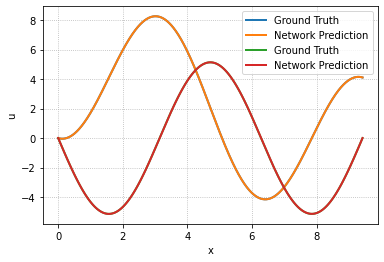

In [8]:
x_test = torch.linspace(0, 3*pi, 10000).reshape(-1,1)
t_test = 4*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")